# 摩拜单车数据集解释分析

##  by Fengyu Jiang

## Investigation Overview

> 调研摩拜单车的骑行时间受哪些因素的影响，集中在开始骑行时间、骑行时间是否为工作日、骑行距离等

## Dataset Overview

> 摩拜单车的数据集包含了约 102361 条骑行数据，包含了订单ID（orderid）、自行车ID(bikeid)、用户ID（userid）、开始骑行时间(start_time)、开始骑行位置(start_location_x, start_location_y)、结束骑行时间(end_time)、结束骑行位置(end_location_x, end_location_y)、骑行轨迹(track)等属性。
> 
> 根据数据集原有信息中新增是否为工作日(weekday)、骑行时间(cycle_time)、骑行距离(cycle_distance)等列。
>
> 根据骑行时间(cycle_time) 99% 分位数去除了 1027 条异常值; 根据骑行距离(cycle_distance) 99%分位数去除了  1014 条异常值。

In [22]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [23]:
# load in the dataset into a pandas dataframe
data = pd.read_csv('../Mobike Data/mobike_shanghai_sample_updated.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102361 entries, 0 to 102360
Data columns (total 10 columns):
orderid             102361 non-null int64
bikeid              102361 non-null int64
userid              102361 non-null int64
start_time          102361 non-null object
start_location_x    102361 non-null float64
start_location_y    102361 non-null float64
end_time            102361 non-null object
end_location_x      102361 non-null float64
end_location_y      102361 non-null float64
track               102361 non-null object
dtypes: float64(4), int64(3), object(3)
memory usage: 7.8+ MB


In [24]:
#修正 start_time 和 end_time 的数据类型
data['start_time']= pd.to_datetime(data['start_time'])
data['end_time']= pd.to_datetime(data['end_time'])

#新增列：开始骑行小时
start_time = data['start_time']
data['start_hour']= start_time.dt.hour

#新增列：骑行时间
data['cycle_time'] = data['end_time'] - data['start_time']
data['cycle_time'] = data['cycle_time'].dt.components.minutes + data['cycle_time'].dt.components.hours * 60

#新增列：区分是否为工作日
data['day_number'] = start_time.dt.weekday
data['weekday'] = np.where(data['day_number'] < 5,"weekday","weekend" )

#新增列：骑行距离
def distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist 
    return km

data['cycle_distance'] = distance(data['start_location_x'],data['start_location_y'],data['end_location_x'],data['end_location_y'])

#去除骑行时间中的异常值
q_time = data['cycle_time'].quantile(0.99)
mobike_data = data[data['cycle_time']<q_time]

#去除骑行距离中的异常值
q_distance = mobike_data['cycle_distance'].quantile(0.99)
mobike_data = mobike_data[mobike_data['cycle_distance'] < q_distance]

mobike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100320 entries, 0 to 102360
Data columns (total 15 columns):
orderid             100320 non-null int64
bikeid              100320 non-null int64
userid              100320 non-null int64
start_time          100320 non-null datetime64[ns]
start_location_x    100320 non-null float64
start_location_y    100320 non-null float64
end_time            100320 non-null datetime64[ns]
end_location_x      100320 non-null float64
end_location_y      100320 non-null float64
track               100320 non-null object
start_hour          100320 non-null int64
cycle_time          100320 non-null int64
day_number          100320 non-null int64
weekday             100320 non-null object
cycle_distance      100320 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(6), object(2)
memory usage: 12.2+ MB


## 工作日和周末开始骑行时间的对比

> 根据数据集观察 ，工作日的开始骑行时间在上下班高峰期明显；周末的开始骑行时间相较于工作日高峰期相对平缓，在10点到18点间同样有大量订单分布。

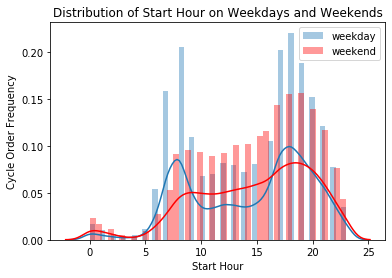

In [25]:
base_color = sb.color_palette()[0]

plt.title('Distribution of Start Hour on Weekdays and Weekends')

sb.distplot(mobike_data.query('weekday=="weekday"')['start_hour'],
            color=base_color,label='weekday')
sb.distplot(mobike_data.query('weekday=="weekend"')['start_hour'],
            color='red',label='weekend')

plt.xlabel('Start Hour')
plt.ylabel('Cycle Order Frequency')

plt.legend()
plt.show()


## 骑行时长受到工作日/周末开始骑行时间的影响

> 整体来看，骑行时长在6点到20点间，随着开始骑行时间的推迟，骑行时间明显增加；同时，周末的开始骑行时间在上午9点到下午4点和晚上7点到10点间显著超过工作日对应时段的平均骑行时间。

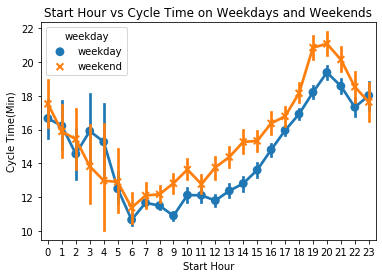

In [26]:
sb.pointplot(data=mobike_data,x="start_hour", y="cycle_time",markers=["o", "x"],
           hue="weekday",hue_order=["weekday","weekend"])

plt.xlabel('Start Hour')
plt.ylabel('Cycle Time(Min)')
plt.title('Start Hour vs Cycle Time on Weekdays and Weekends')

plt.show()

## 骑行时长受到工作日/周末的骑行距离的影响
> 整体来看，随着骑行距离的增加骑行时长也会增加；但工作日更容易出现骑行距离长、骑行时间长的骑行情况（斜率更陡）；周末的骑行时间和骑行距离相对集中在5km/40分钟以内。


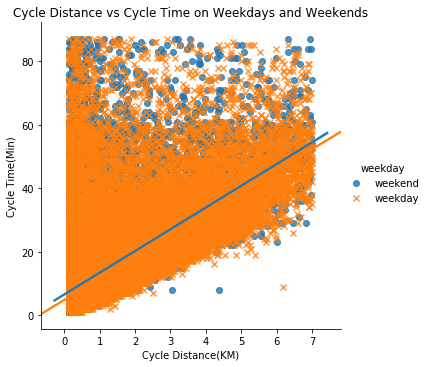

In [27]:

sb.lmplot(x="cycle_distance",y="cycle_time",
         # col="weekday", 
          hue="weekday",
          markers=["o", "x"],
          data=mobike_data)

plt.title('Cycle Distance vs Cycle Time on Weekdays and Weekends')
plt.xlabel('Cycle Distance(KM)')
plt.ylabel('Cycle Time(Min)')
plt.show()
